<a href="https://colab.research.google.com/github/snikhil17/REGex_Internship/blob/main/Team%20Project%20-%203/2_Hyper_parameter_Tuning%2C_model_building_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem**

- It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# **Given Data**
- The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# **Acknowledgements**

- The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

# **Importing Required Libraries**

### **Uncomment to install following libraries**

In [ ]:

# !pip install xgboost
# !pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from imblearn.combine import SMOTETomek
import optuna
import itertools
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import pickle

## **Loading the Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train= pd.read_csv('/content/drive/MyDrive/Regex Team 3/Team Project - 3/creditcard.csv')
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#normal distributed outliers treatment by [min :mean-3*(sigma) or above: mean+3*(sigma)]
j=0
ND_h=[]
ND_l=[]
ND_out=['V9','V10','V13','V15','V19','V20','V21','V22','V25','V27'] #by oberving the distribution diagrams
for i in ND_out[:]:
    m=min(df_train[i].max(),abs(df_train[i].min()))
    ND_h.append(round(df_train[i].mean() + (m-((m//5)*1.25))*df_train[i].std(),1))
    ND_l.append(round(df_train[i].mean() - (m-((m//5)*1.25))*df_train[i].std(),1))
    new_df = df_train[(df_train[i] < ND_h[j]) & (df_train[i] > ND_l[j])]
    df_train[i] = np.where( df_train[i]>ND_h[j],ND_h[j],np.where( df_train[i]<ND_l[j],  ND_l[j],  df_train[i] ))
    j=j+1

SD_out=['V1','V2','V3','V4','V5','V6','V7','V8','V11','V12','V14','V16','V17','V18','V23','V26'] #by oberving the distribution diagrams
#Skewed distribution outliers treatment
for i in SD_out[:]:
    p25 = new_df[i].quantile(0.25)
    p75 = new_df[i].quantile(0.75)
    iqr=p75-p25
    ul = p75 + 1.5 * iqr
    ll = p25 - 1.5 * iqr
    new_df1 = new_df[new_df[i] < ul]#trimming
    #capping
    new_df[i] = np.where( 
    new_df[i] > ul,
    ul,
    np.where(
        new_df[i] < ll,
        ll,
        new_df[i]
            )
    )

OD_out=['V24','V28','Amount'] #by oberving the distribution diagrams
#Other distributed outliers treatment by percentile
for i in OD_out[:]:
    upper_limit = new_df1[i].quantile(0.99)
    lower_limit = new_df1[i].quantile(0.01)
    new_df2 = new_df1[(new_df1[i] <= upper_limit) & (new_df1[i] >= lower_limit)]#trimming
    #capping
    new_df1[i] = np.where(new_df1[i] >= upper_limit,
            upper_limit,
            np.where(new_df1[i] <= lower_limit,
            lower_limit,
            new_df1[i]))

# **Evaluation**
### **Confusion Matrix**

- **Confusion matrix**: A confusion matrix is a table that is often used to describe the performance of a classification model true positives (TP): These are cases in which we predicted yes.

- **true negatives (TN):** We predicted no, and they don't have the disease.

- **false positives (FP):** We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

- **false negatives (FN):** We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

- **precision** - What proportion of positive identifications was actually correct? 

- **recall** - What proportion of actual positives was identified correctly?

- **F1 Score:**
    - F1 Score is the weighted average of Precision and Recall
    - F1 is usually more useful than accuracy, especially if you have an uneven class distribution.



In [ ]:
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Hide grid lines
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## **Preprocessing** 

In [ ]:
# Standardizing Amount
new_df2['normalized_amount']=StandardScaler().fit_transform(new_df2['Amount'].values.reshape(-1,1))
# Dropping the actual Amount column from the dataset.
new_df2=new_df2.drop(['Amount'],axis=1)


# Standardizing Time
new_df2['normalized_time']=StandardScaler().fit_transform(new_df2['Time'].values.reshape(-1,1))
# Dropping the actual Amount column from the dataset.
new_df2=new_df2.drop(['Time'],axis=1)

useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]

In [ ]:
#Create independent and Dependent Features
columns = new_df2.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = new_df2[columns]
Y = new_df2[[target]]


# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(274396, 30)
(274396, 1)


# **Taking care of Imbalanced Dataset**
## **Using ``SMOTETomek``**

In [ ]:
%%time

# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
col_X = list(X.columns)
col_y = list(Y.columns)
X_res,y_res=smk.fit_sample(X,Y)

print(X_res.shape,y_res.shape)

(547914, 30) (547914,)
CPU times: user 9min 20s, sys: 821 ms, total: 9min 21s
Wall time: 9min 17s


In [ ]:
X = pd.DataFrame(X_res, columns = col_X)
Y = pd.DataFrame(y_res, columns = col_y)

df = X
df['Class'] = y_res
print(f"shape of dataset resampling: {df.shape}")

from collections import Counter
print(f'Original dataset Class variable count {Counter(new_df2["Class"])}')
print(f'Resampled dataset Class variable count {Counter(df["Class"])}')

shape of dataset resampling: (547914, 31)
Original dataset Class variable count Counter({0: 273957, 1: 439})
Resampled dataset Class variable count Counter({0: 273957, 1: 273957})


## **Creating Train and Test data set from resampled data.**

In [ ]:
df_train, df_test = train_test_split(df, test_size= 0.2, stratify=df['Class'], random_state = 7)

# **Hyperparameter Tuning**
### **Now, let’s see where will a hyperparameter optimizer stands in the whole process of learning the algorithm.**
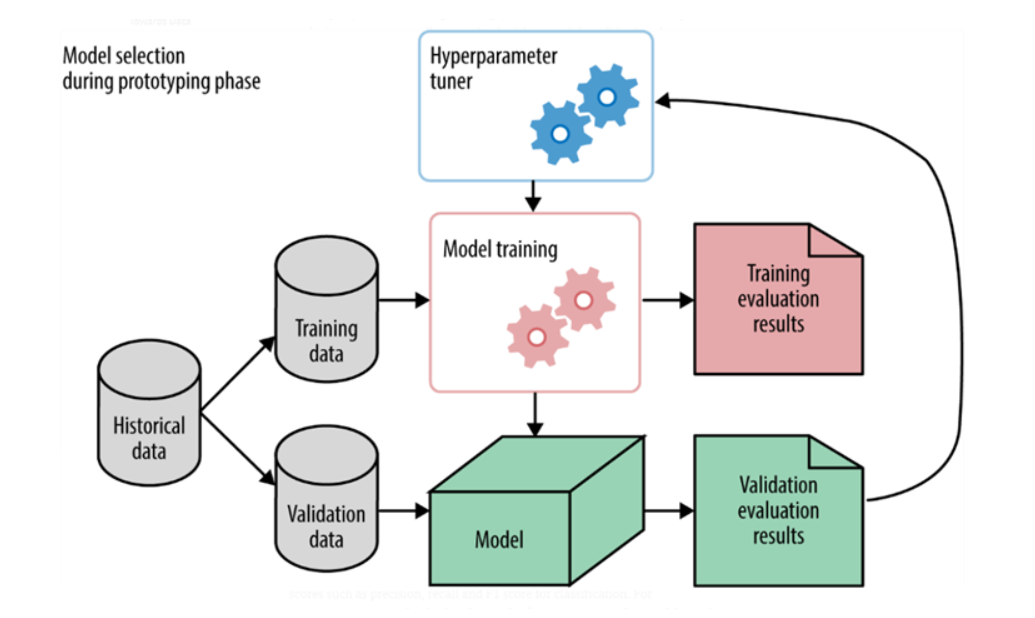

**As can be seen in the above figure, the hyperparameter tuner is external to the model and the tuning is done before model training. The result of the tuning process is the optimal values of hyperparameters which is then fed to the model training stage. Let me now introduce Optuna, an optimization library in Python that can be employed for hyperparameter optimization.**

## **Optuna**

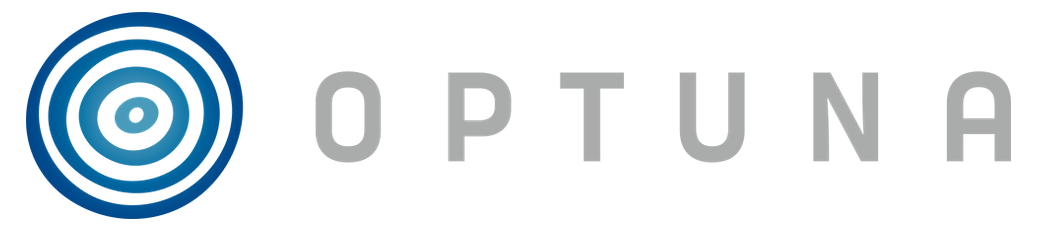

**Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically finds optimal hyperparameter values by making use of different samplers such as grid search, random, bayesian, and evolutionary algorithms. Let me first briefly describe the different samplers available in optuna.**

- Grid Search: The search space of each hyper-parameter is discretized. The optimizer launches learning for each of the hyper-parameter configurations and selects the best at the end.
- Random: Randomly samples the search space and continues until the stopping criteria are met.
- Bayesian: Probabilistic model-based approach for finding the optimal hyperparameters
- Evolutionary algorithms: •Meta-heuristic approaches that employ the value of the fitness function to find the optimal hyperparameters.

## **Why Optuna?** 
The following features of optuna encouraged us to use it for hyperparameter tuning for the problems we were trying to solve!
- Eager dynamic search spaces
- Efficient sampling and pruning algorithms
- Easy integration
- Good visualizations
- Distributed optimization

## **Modelling Deep Neural Model**
- Neural networks reflect the behavior of the human brain, allowing computer programs to recognize patterns and solve common problems in the fields of AI, machine learning, and deep learning.
- Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons signal to one another.

- Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

---



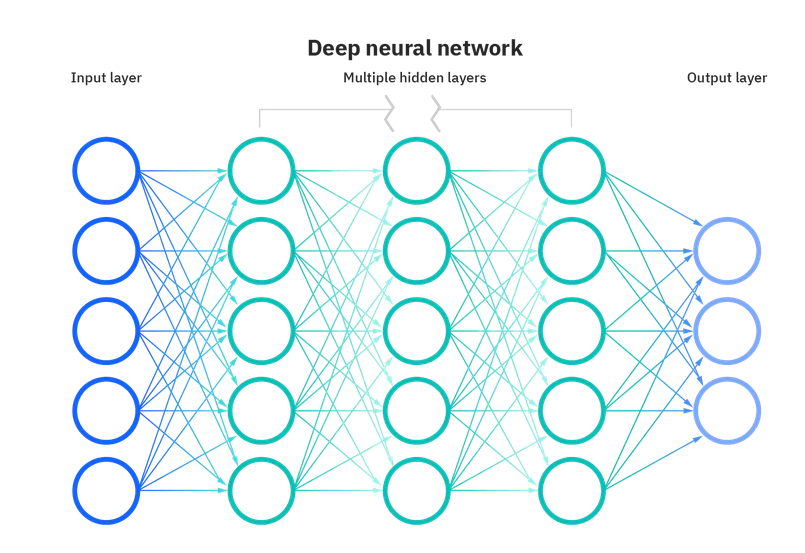


---


- Neural networks rely on training data to learn and improve their accuracy over time. However, once these learning algorithms are fine-tuned for accuracy, they are powerful tools in computer science and artificial intelligence, allowing us to classify and cluster data at a high velocity. Tasks in speech recognition or image recognition can take minutes versus hours when compared to the manual identification by human experts. One of the most well-known neural networks is Google’s search algorithm.

## **MLPClassifier**
- We are using MLPClassifier from scikit-learn to use Neural Network.
- MLPClassifier stands for Multi-layer Perceptron classifier which in the name itself connects to a Neural Network. Unlike other classification algorithms such as Support Vectors or Naive Bayes Classifier, MLPClassifier relies on an underlying Neural Network to perform the task of classification.

- One similarity though, with Scikit-Learn’s other classification algorithms is that implementing MLPClassifier takes no more effort than implementing Support Vectors or Naive Bayes or any other classifiers from Scikit-Learn. 

# **Plan for Parameter Tuning, Model building and Evaluation:**

---


- We will use stratifyKfold CV on training data to create 5 folds and perform hyper parameter tuning for 3 models using Optuna.
- Next we will use the best parameters suggested by Optuna to train 3 models and use test data to check our results.
- Finally we will use Voting Classifier to select the best result from 3 models.
- Each model will be evaluated using roc_auc_curve when being hypertune.
- When training each model's classification report and confusion matrix will also be considered. 


In [ ]:
# Preparing data as a tabular matrix
y_train = df_train.Class
X_train = df_train.drop('Class', axis=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

## **Hypertuning Random Forest using Optuna**

In [ ]:
%%time

def objective(trial):
  for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )): # creating Stratify-5-Folds
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]         # assigning xtrain, ytrain
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]         # assigning xvalid, yvalid

    xtrain = xtrain[useful_features]                                                    # removed Class variable
    xvalid = xvalid[useful_features]                                                    # removed Class variable
  
    
    # Modelling 
    params =   {'n_estimators' : trial.suggest_int('n_estimators', 10, 20)
    ,'max_depth' : trial.suggest_int('max_depth', 3, 10)
    }
    model = RandomForestClassifier(**params,criterion = 'entropy',random_state= 5)# Initialization of RandomForestClassifier Class
    model.fit(xtrain,ytrain)                                                      # Training the Model on training set

    # Predictions and Evaluation
    preds_valid = model.predict_proba(xvalid)[:, 1]                               # Validating the model on Validation data.
    roc_auc_score = metrics.roc_auc_score(yvalid, preds_valid)                    # Evaluating the model using roc_aucc_curve
    print(fold, roc_auc_score)

  return roc_auc_score
study_rf = optuna.create_study(direction='maximize')                             # direction = "maximize", optuna will try to maximize the roc_auc_score
study_rf.optimize(objective, n_trials=15)                                        # Running our objective function for 15 trials.

[I 2021-11-13 16:26:32,727] A new study created in memory with name: no-name-3ec5562a-f8db-4c3b-a34c-f56271454eaa


0 0.9973675838400127
1 0.9978046793871748
2 0.9972614512723574
3 0.9975399005621771


[I 2021-11-13 16:28:12,973] Trial 0 finished with value: 0.9977369859809786 and parameters: {'n_estimators': 11, 'max_depth': 7}. Best is trial 0 with value: 0.9977369859809786.


4 0.9977369859809786
0 0.9991245936540464
1 0.9995235812692016
2 0.99916666479687
3 0.999178293709151


[I 2021-11-13 16:30:12,872] Trial 1 finished with value: 0.9993113579139684 and parameters: {'n_estimators': 11, 'max_depth': 9}. Best is trial 1 with value: 0.9993113579139684.


4 0.9993113579139684
0 0.9895560382749543
1 0.9894252603538607
2 0.9891374194018804
3 0.9893354143460011


[I 2021-11-13 16:31:49,107] Trial 2 finished with value: 0.9890167356713248 and parameters: {'n_estimators': 16, 'max_depth': 4}. Best is trial 1 with value: 0.9993113579139684.


4 0.9890167356713248
0 0.9960158102278758
1 0.9959761290882316
2 0.9960815598579803
3 0.9948802947287156


[I 2021-11-13 16:33:37,622] Trial 3 finished with value: 0.9951516624726151 and parameters: {'n_estimators': 12, 'max_depth': 6}. Best is trial 1 with value: 0.9993113579139684.


4 0.9951516624726151
0 0.9996894360675179
1 0.999737111009872
2 0.9997506406869406
3 0.9995484967979938


[I 2021-11-13 16:36:44,197] Trial 4 finished with value: 0.9997479875794639 and parameters: {'n_estimators': 16, 'max_depth': 10}. Best is trial 4 with value: 0.9997479875794639.


4 0.9997479875794639
0 0.9844781881239988
1 0.9845224743990078
2 0.9843349849277394
3 0.9846053580491008


[I 2021-11-13 16:37:33,267] Trial 5 finished with value: 0.9838726517384107 and parameters: {'n_estimators': 10, 'max_depth': 3}. Best is trial 4 with value: 0.9997479875794639.


4 0.9838726517384107
0 0.9996304621777666
1 0.9996930915458302
2 0.9997003011279328
3 0.9994080858666267


[I 2021-11-13 16:39:34,189] Trial 6 finished with value: 0.9996274415138279 and parameters: {'n_estimators': 10, 'max_depth': 10}. Best is trial 4 with value: 0.9997479875794639.


4 0.9996274415138279
0 0.9844781881239988
1 0.9845224743990078
2 0.9843349849277394
3 0.9846053580491008


[I 2021-11-13 16:40:22,510] Trial 7 finished with value: 0.9838726517384107 and parameters: {'n_estimators': 10, 'max_depth': 3}. Best is trial 4 with value: 0.9997479875794639.


4 0.9838726517384107
0 0.9845517002946704
1 0.9842655690185133
2 0.9840292196909453
3 0.9845579263687534


[I 2021-11-13 16:41:34,288] Trial 8 finished with value: 0.9839496889233176 and parameters: {'n_estimators': 16, 'max_depth': 3}. Best is trial 4 with value: 0.9997479875794639.


4 0.9839496889233176
0 0.9848614015640196
1 0.9841967493102906
2 0.9843604917130485
3 0.9842252704108426


[I 2021-11-13 16:43:05,625] Trial 9 finished with value: 0.9841066917304468 and parameters: {'n_estimators': 20, 'max_depth': 3}. Best is trial 4 with value: 0.9997479875794639.


4 0.9841066917304468
0 0.9988305988390125
1 0.9987924303899378
2 0.9985863980525439
3 0.9988853060669727


[I 2021-11-13 16:46:17,373] Trial 10 finished with value: 0.9988698904585765 and parameters: {'n_estimators': 19, 'max_depth': 8}. Best is trial 4 with value: 0.9997479875794639.


4 0.9988698904585765
0 0.9996947637605259
1 0.9997138565683796
2 0.9997344433291712
3 0.9995132964765985


[I 2021-11-13 16:48:57,906] Trial 11 finished with value: 0.9997035902525427 and parameters: {'n_estimators': 14, 'max_depth': 10}. Best is trial 4 with value: 0.9997479875794639.


4 0.9997035902525427
0 0.9996947637605259
1 0.9997138565683796
2 0.9997344433291712
3 0.9995132964765985


[I 2021-11-13 16:51:42,958] Trial 12 finished with value: 0.9997035902525427 and parameters: {'n_estimators': 14, 'max_depth': 10}. Best is trial 4 with value: 0.9997479875794639.


4 0.9997035902525427
0 0.9990632100325872
1 0.9994999554707333
2 0.999157476639373
3 0.9992960562890028


[I 2021-11-13 16:54:11,352] Trial 13 finished with value: 0.9993518077188381 and parameters: {'n_estimators': 14, 'max_depth': 9}. Best is trial 4 with value: 0.9997479875794639.


4 0.9993518077188381
0 0.9959526971164675
1 0.9963900377963278
2 0.9962655642468234
3 0.9954814235636725


[I 2021-11-13 16:56:33,708] Trial 14 finished with value: 0.9954152210503389 and parameters: {'n_estimators': 18, 'max_depth': 6}. Best is trial 4 with value: 0.9997479875794639.


4 0.9954152210503389
CPU times: user 30min 8s, sys: 2.94 s, total: 30min 11s
Wall time: 30min


In [ ]:
trial_rf = study_rf.best_trial
print('roc_auc_score: {}'.format(trial_rf.value))
print("Best hyperparameters: {}".format(trial_rf.params))

Accuracy: 0.9997479875794639
Best hyperparameters: {'n_estimators': 16, 'max_depth': 10}


In [ ]:
optuna.visualization.plot_optimization_history(study_rf)

In [ ]:
optuna.visualization.plot_slice(study_rf)

## **Hypertuning XGBoost using optuna**

In [ ]:
%%time
import xgboost as xgb
def objective(trial):
  for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]

    xtrain = xtrain[useful_features]           # creating xtrain
    xvalid = xvalid[useful_features]           # creating xvalid
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 40), 
        'n_estimators': trial.suggest_int('n_estimators', 500, 700), 
        'eta': trial.suggest_float('eta', 0.007, 0.013), 
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e4), 
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e4),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e4), 
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e4),
        'eval_metric' : 'auc',
        'objective' : 'binary:logistic',
        }

    model = XGBClassifier(**params,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor", 
            random_state=42, use_label_encoder=False)
    model.fit(xtrain,ytrain,eval_set=[(xvalid,yvalid)], early_stopping_rounds=300, verbose=100)

    preds_valid = model.predict_proba(xvalid)[:, 1]
    roc_auc_score = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc_score)

  return roc_auc_score
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=5)

[I 2021-11-14 14:25:36,237] A new study created in memory with name: no-name-63b456e8-9753-4313-82c0-9fadf076a772


[0]	validation_0-auc:0.971064
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.992069
[200]	validation_0-auc:0.992978
[300]	validation_0-auc:0.993489
[400]	validation_0-auc:0.993753
[500]	validation_0-auc:0.993904
[564]	validation_0-auc:0.993906
0 0.9939144648461422
[0]	validation_0-auc:0.971133
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.992131
[200]	validation_0-auc:0.993016
[300]	validation_0-auc:0.993502
[400]	validation_0-auc:0.993788
[500]	validation_0-auc:0.993952
[564]	validation_0-auc:0.993946
1 0.9939581437926158
[0]	validation_0-auc:0.971244
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.9921
[200]	validation_0-auc:0.992926
[300]	validation_0-auc:0.993416
[400]	validation_0-auc:0.993675
[500]	validation_0-auc:0.993805
[564]	validation_0-auc:0.993839
2 0.9938385824605445
[0]	validation_0-auc:0.970771
Will train until validation_0-auc hasn't improve

[I 2021-11-14 14:46:55,273] Trial 0 finished with value: 0.9937332149281785 and parameters: {'max_depth': 25, 'n_estimators': 565, 'eta': 0.008923151796725528, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'min_child_weight': 5899.378957754419, 'reg_lambda': 0.0042186657023481145, 'reg_alpha': 0.018512126892456106, 'gamma': 1.9535339084231342}. Best is trial 0 with value: 0.9937332149281785.


[0]	validation_0-auc:0.985092
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999934
[200]	validation_0-auc:0.999974
[300]	validation_0-auc:0.999979
[400]	validation_0-auc:0.999983
[500]	validation_0-auc:0.999985
[539]	validation_0-auc:0.999985
0 0.9999846271608088
[0]	validation_0-auc:0.985226
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999934
[200]	validation_0-auc:0.999985
[300]	validation_0-auc:0.999995
[400]	validation_0-auc:0.999997
[500]	validation_0-auc:0.999998
[539]	validation_0-auc:0.999998
1 0.9999975311397125
[0]	validation_0-auc:0.984673
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999962
[200]	validation_0-auc:0.999988
[300]	validation_0-auc:0.999991
[400]	validation_0-auc:0.999992
[500]	validation_0-auc:0.999993
[539]	validation_0-auc:0.999993
2 0.999992523415615
[0]	validation_0-auc:0.985372
Will train until validation_0-auc hasn't improv

[I 2021-11-14 15:01:30,153] Trial 1 finished with value: 0.9999724974637112 and parameters: {'max_depth': 14, 'n_estimators': 540, 'eta': 0.010626435887330877, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.5, 'min_child_weight': 0.03143019923085157, 'reg_lambda': 41.84548138720466, 'reg_alpha': 0.2234103308119991, 'gamma': 1298.615736338399}. Best is trial 1 with value: 0.9999724974637112.


[0]	validation_0-auc:0.975106
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999894
[200]	validation_0-auc:0.999937
[300]	validation_0-auc:0.99995
[400]	validation_0-auc:0.999959
[500]	validation_0-auc:0.999962
[513]	validation_0-auc:0.999962
0 0.999961537194858
[0]	validation_0-auc:0.990107
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999891
[200]	validation_0-auc:0.999945
[300]	validation_0-auc:0.99997
[400]	validation_0-auc:0.999981
[500]	validation_0-auc:0.999986
[513]	validation_0-auc:0.999987
1 0.9999865005103238
[0]	validation_0-auc:0.974688
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999944
[200]	validation_0-auc:0.999962
[300]	validation_0-auc:0.999974
[400]	validation_0-auc:0.999981
[500]	validation_0-auc:0.999984
[513]	validation_0-auc:0.999984
2 0.9999835999182752
[0]	validation_0-auc:0.976009
Will train until validation_0-auc hasn't improved

[I 2021-11-14 15:11:31,781] Trial 2 finished with value: 0.9999664792426707 and parameters: {'max_depth': 18, 'n_estimators': 514, 'eta': 0.012411445857696721, 'subsample': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0015780612932429076, 'reg_lambda': 123.69150937075419, 'reg_alpha': 0.025737467593930724, 'gamma': 3094.6465127421766}. Best is trial 1 with value: 0.9999724974637112.


[0]	validation_0-auc:0.999457
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999988
[200]	validation_0-auc:0.99999
[300]	validation_0-auc:0.99999
Stopping. Best iteration:
[60]	validation_0-auc:0.999991

0 0.9999912073417986
[0]	validation_0-auc:0.999494
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999998
[200]	validation_0-auc:0.999999
[300]	validation_0-auc:1
[400]	validation_0-auc:1
[500]	validation_0-auc:1
Stopping. Best iteration:
[232]	validation_0-auc:1

1 0.9999994941009381
[0]	validation_0-auc:0.999556
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999985
[200]	validation_0-auc:0.999988
[300]	validation_0-auc:0.99999
Stopping. Best iteration:
[35]	validation_0-auc:0.999991

2 0.9999909916656778
[0]	validation_0-auc:0.99944
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999978
[200]	validation_0-auc:0.99998

[I 2021-11-14 15:21:58,179] Trial 3 finished with value: 0.9999811292363346 and parameters: {'max_depth': 22, 'n_estimators': 678, 'eta': 0.011516668782211492, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 0.5868048495053659, 'reg_lambda': 0.05826181075186373, 'reg_alpha': 0.3470440059008617, 'gamma': 85.41232538135233}. Best is trial 3 with value: 0.9999811292363346.


4 0.9999811292363346
[0]	validation_0-auc:0.95048
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.99625
[200]	validation_0-auc:0.99829
[300]	validation_0-auc:0.998998
[400]	validation_0-auc:0.999308
[500]	validation_0-auc:0.999472
[600]	validation_0-auc:0.999563
[648]	validation_0-auc:0.999596
0 0.9995955005098164
[0]	validation_0-auc:0.949986
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.996287
[200]	validation_0-auc:0.998333
[300]	validation_0-auc:0.998973
[400]	validation_0-auc:0.99926
[500]	validation_0-auc:0.999411
[600]	validation_0-auc:0.999496
[648]	validation_0-auc:0.999531
1 0.9995306183147413
[0]	validation_0-auc:0.951326
Will train until validation_0-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.99623
[200]	validation_0-auc:0.998386
[300]	validation_0-auc:0.999067
[400]	validation_0-auc:0.999366
[500]	validation_0-auc:0.999518
[600]	validation_0-auc:0.999606
[648]	validation_

[I 2021-11-14 15:28:05,362] Trial 4 finished with value: 0.9995585249977601 and parameters: {'max_depth': 6, 'n_estimators': 649, 'eta': 0.01251638305833853, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'min_child_weight': 87.51520191315659, 'reg_lambda': 3405.1791674894243, 'reg_alpha': 0.001668218691737736, 'gamma': 0.33123609713335483}. Best is trial 3 with value: 0.9999811292363346.


4 0.9995585249977601
CPU times: user 1h 2min 41s, sys: 11.2 s, total: 1h 2min 52s
Wall time: 1h 2min 29s


In [ ]:
trial_xgb = study_xgb.best_trial
print('roc_auc_score: {}'.format(trial_xgb.value))
print("Best hyperparameters: {}".format(trial_xgb.params))

Accuracy: 0.9999811292363346
Best hyperparameters: {'max_depth': 22, 'n_estimators': 678, 'eta': 0.011516668782211492, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 0.5868048495053659, 'reg_lambda': 0.05826181075186373, 'reg_alpha': 0.3470440059008617, 'gamma': 85.41232538135233}


In [ ]:
optuna.visualization.plot_optimization_history(study_xgb)

In [ ]:
optuna.visualization.plot_slice(study_xgb)

## **Hypertuning NN** 

In [ ]:
%%time
def objective(trial):
  for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]

    xtrain = xtrain[useful_features]           # creating xtrain
    xvalid = xvalid[useful_features]           # creating xvalid
  

    params = {
        'alpha': trial.suggest_loguniform('alpha',1e-3,1), 
        'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes',5,20),
        'max_iter': trial.suggest_int('max_iter',30,70)}
    
    model_mp= MLPClassifier(**params,random_state=7,tol=1e-4)
    model_mp.fit(xtrain,ytrain)


    preds_valid = model_mp.predict_proba(xvalid)[:, 1]
    roc_auc_score = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc_score)
  return roc_auc_score
study_mp = optuna.create_study(direction='maximize')
study_mp.optimize(objective, n_trials=5)

[I 2021-11-14 07:06:47,808] A new study created in memory with name: no-name-deca8b36-d7a1-4f18-ad6e-e04a83256e5b


0 0.9998881967761223
1 0.9998455331940832
2 0.9991500010959325
3 0.9998244842539019


[I 2021-11-14 07:09:14,852] Trial 0 finished with value: 0.9998823394327163 and parameters: {'alpha': 0.001485616679003466, 'hidden_layer_sizes': 16, 'max_iter': 43}. Best is trial 0 with value: 0.9998823394327163.


4 0.9998823394327163
0 0.9998424118736731
1 0.999752194817186
2 0.9998441175094659
3 0.9997684965296487


[I 2021-11-14 07:11:42,870] Trial 1 finished with value: 0.999813473142224 and parameters: {'alpha': 0.013356656708682125, 'hidden_layer_sizes': 12, 'max_iter': 50}. Best is trial 0 with value: 0.9998823394327163.


4 0.999813473142224
0 0.9999123440574005
1 0.9997960487710409
2 0.9998257568086406
3 0.9998135652658187


[I 2021-11-14 07:14:34,632] Trial 2 finished with value: 0.9998671723498366 and parameters: {'alpha': 0.0039017566458469165, 'hidden_layer_sizes': 19, 'max_iter': 35}. Best is trial 0 with value: 0.9998823394327163.


4 0.9998671723498366
0 0.9998957866503114
1 0.9998993911457428
2 0.9999028304266073
3 0.999895249747765


[I 2021-11-14 07:17:21,482] Trial 3 finished with value: 0.9998883946072891 and parameters: {'alpha': 0.006376011940802892, 'hidden_layer_sizes': 18, 'max_iter': 35}. Best is trial 3 with value: 0.9998883946072891.


4 0.9998883946072891
0 0.9993414885045583
1 0.999283515249041
2 0.99928391809459
3 0.9992314825936873


[I 2021-11-14 07:20:28,011] Trial 4 finished with value: 0.9991993377048457 and parameters: {'alpha': 0.08419645817851845, 'hidden_layer_sizes': 8, 'max_iter': 64}. Best is trial 3 with value: 0.9998883946072891.


4 0.9991993377048457
CPU times: user 13min 39s, sys: 7.47 s, total: 13min 47s
Wall time: 13min 40s


In [ ]:
trial_mp = study_mp.best_trial
print('roc_auc_score: {}'.format(trial_mp.value))
print("Best hyperparameters: {}".format(trial_mp.params))

Accuracy: 0.9998883946072891
Best hyperparameters: {'alpha': 0.006376011940802892, 'hidden_layer_sizes': 18, 'max_iter': 35}


In [ ]:
optuna.visualization.plot_optimization_history(study_mp)

In [ ]:
optuna.visualization.plot_slice(study_mp)

# **Model Building - Random Forest**

In [ ]:
# %%time
useful_features = [c for c in df_train.columns if c not in ("Class")]

final_test_predictions_rf = [] #to store final test predictions
final_valid_predictions_rf = [] # to store final validation predictions
scores = [] #to store the scores
xtest, ytest = df_test.copy(), df_test['Class'].copy()


for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):   # creating Stratify-5-Folds
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]         # creating xtrain, ytrain
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]         # creating xvalid and yvalid
    
    
    xtrain = xtrain[useful_features]                                                    # Removing Class variable
    xvalid = xvalid[useful_features]                                                    # Removing Class variable
    xtest = xtest[useful_features]                                                      # Removing Class variable

    # Model building using parameters obtain from Optuna hyper-parameter tuning
    params = {'n_estimators': 16, 'max_depth': 10}
    model_rf = RandomForestClassifier(**params,criterion = 'entropy',random_state= 7)   # instantiate RandomForestClassifier Class
    model_rf.fit(xtrain, ytrain)                                                        # Training the model on training set

    preds_valid = model_rf.predict_proba(xvalid)[:, 1]                                  # Predicting Validation set 
    test_preds = model_rf.predict_proba(xtest)[:, 1]                                    # Predicting Test Set
    final_test_predictions_rf.append(test_preds)                                        # Appending test predictions to list
    final_valid_predictions_rf.append(preds_valid)                                      # Appending valid predictions to list
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)                    # Evaluating valid predictions using roc_auc_curve      
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)                       # Evaluating test predictions using roc_auc_curve
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)                              # printing fold and respective roc_auc for validation set 
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)                                # printing fold and respective roc_auc for test set
    scores.append(roc_auc_score_valid)                                                  # Appending roc_auc_score to list.
    
print(np.mean(scores), np.std(scores))                                                  # printing mean and standard deviation of scores 

Fold 0 AUC_valid:  0.9997264517324842
Fold 0 AUC_test:  0.9997544803904075
Fold 1 AUC_valid:  0.9996865195422778
Fold 1 AUC_test:  0.9996724005780695
Fold 2 AUC_valid:  0.9995757422209735
Fold 2 AUC_test:  0.9996347383812985
Fold 3 AUC_valid:  0.9995865347342914
Fold 3 AUC_test:  0.999637367700017
Fold 4 AUC_valid:  0.9996864357462398
Fold 4 AUC_test:  0.9997213991407037
0.9996523367952532 6.003476094599392e-05


## **Evaluation of Random Forest model**

Confusion matrix, without normalization
[[54650   141]
 [  681 54111]]


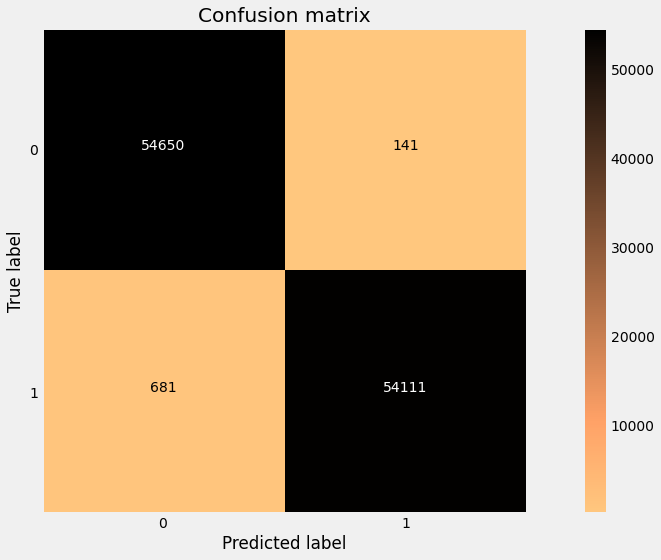

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     54791
           1       1.00      0.99      0.99     54792

    accuracy                           0.99    109583
   macro avg       0.99      0.99      0.99    109583
weighted avg       0.99      0.99      0.99    109583



In [ ]:
cnf_matrix=metrics.confusion_matrix(ytest,(np.mean(np.column_stack(final_test_predictions_rf), axis=1)).round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()


print(classification_report(ytest,(np.mean(np.column_stack(final_test_predictions_rf), axis=1)).round()))

## **Saving the Random Forest Model**

In [ ]:
# Save the model
"""Save the model"""
output_file = f'model_rf.bin'
with open(output_file, 'wb') as f_out:
    pickle.dump((model_rf), f_out)

print(f'the model is saved to {output_file}')

the model is saved to model_rf.bin


# **Model Building - XGBOOST**


In [ ]:
# %%time
useful_features = [c for c in df_train.columns if c not in ("Class")]

final_test_predictions_xgb = [] #to store final test predictions
final_valid_predictions_xgb = [] # to store final validation predictions
scores = [] #to store the scores


# using for loop for 5 folds XGBoost
for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]
    xtest, ytest = df_test.copy(), df_test['Class'].copy()
    
    #creating xtrain and xvalid
    xtrain = xtrain[useful_features].values
    xvalid = xvalid[useful_features].values
    xtest = xtest[useful_features].values    
    
    params = {'max_depth': 22, 'n_estimators': 678, 'eta': 0.011516668782211492, 'subsample': 0.8,
              'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 0.5868048495053659,
              'reg_lambda': 0.05826181075186373, 'reg_alpha': 0.3470440059008617, 'gamma': 85.41232538135233}

    model_xgb = XGBClassifier(**params, random_state= 7, 
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor"
            )
    model_xgb.fit(xtrain, 
            ytrain,
            eval_set=[(xvalid, yvalid)],
            early_stopping_rounds=200,
            verbose=500,eval_metric= 'auc',
        )

    preds_valid = model_xgb.predict_proba(xvalid)[:, 1]
    test_preds = model_xgb.predict_proba(xtest)[:, 1]    
    final_test_predictions_xgb.append(test_preds)
    final_valid_predictions_xgb.append(preds_valid)
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)
    scores.append(roc_auc_score_valid)
    
    
print(np.mean(scores), np.std(scores))

[0]	validation_0-auc:0.999298
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[53]	validation_0-auc:0.999992

Fold 0 AUC_valid:  0.9999922310874292
Fold 0 AUC_test:  0.9999995110103403
[0]	validation_0-auc:0.999287
Will train until validation_0-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.999999
Stopping. Best iteration:
[307]	validation_0-auc:0.999999

Fold 1 AUC_valid:  0.9999985018205253
Fold 1 AUC_test:  0.9999999886746265
[0]	validation_0-auc:0.999467
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[24]	validation_0-auc:0.999992

Fold 2 AUC_valid:  0.9999922080094096
Fold 2 AUC_test:  0.9999992934965476
[0]	validation_0-auc:0.999293
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[26]	validation_0-auc:0.999993

Fold 3 AUC_valid:  0.9999926035683468
Fold 3 AUC_test:  0.9999892360651518
[0]	validation_0-auc:0.999557
Will train until validati

## **Evaluation of XGBoost model**

Confusion matrix, without normalization
[[54778    13]
 [    0 54792]]


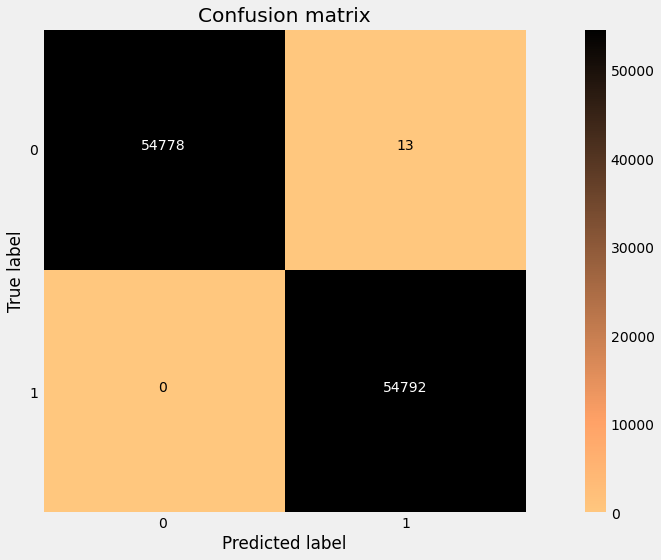

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54791
           1       1.00      1.00      1.00     54792

    accuracy                           1.00    109583
   macro avg       1.00      1.00      1.00    109583
weighted avg       1.00      1.00      1.00    109583



In [ ]:
cnf_matrix=metrics.confusion_matrix(ytest,(np.mean(np.column_stack(final_test_predictions_xgb), axis=1)).round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()


print(classification_report(ytest,(np.mean(np.column_stack(final_test_predictions_xgb), axis=1)).round()))

## **Saving XGBoost Model**

In [ ]:
# Save the model
"""Save the model"""
output_file = f'model_xgb.bin'
with open(output_file, 'wb') as f_out:
    pickle.dump((model_xgb), f_out)

print(f'the model is saved to {output_file}')

the model is saved to model_xgb.bin


# **Model building - Neural Networks**

In [ ]:
# %%time
useful_features = [c for c in df_train.columns if c not in ("Class")]

final_test_predictions_mp = [] #to store final test predictions
final_valid_predictions_mp = [] # to store final validation predictions
scores = [] #to store the scores
xtest, ytest = df_test.copy(), df_test['Class'].copy()

# using for loop for 5 folds XGBoost
for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]
    
    #creating xtrain and xvalid
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    params = {'alpha': 0.006376011940802892, 'hidden_layer_sizes': 18, 'max_iter': 35}
    
    model_mp= MLPClassifier(**params, random_state=7,tol=1e-4)
    model_mp.fit(xtrain,ytrain)
    

    preds_valid = model_mp.predict_proba(xvalid)[:, 1]
    test_preds = model_mp.predict_proba(xtest)[:, 1]    
    final_test_predictions_mp.append(test_preds)
    final_valid_predictions_mp.append(preds_valid)
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)
    scores.append(roc_auc_score_valid)
    
    
print(np.mean(scores), np.std(scores))

Fold 0 AUC_valid:  0.9998957866503114
Fold 0 AUC_test:  0.9999120767945389
Fold 1 AUC_valid:  0.9998993911457428
Fold 1 AUC_test:  0.9999257045499587
Fold 2 AUC_valid:  0.9999028304266073
Fold 2 AUC_test:  0.9999240710313682
Fold 3 AUC_valid:  0.999895249747765
Fold 3 AUC_test:  0.9999253131583715
Fold 4 AUC_valid:  0.9998883946072891
Fold 4 AUC_test:  0.9999248847927704
0.9998963305155432 4.817858222464812e-06


## **Evaluation of Neural Network model**

Confusion matrix, without normalization
[[54680   111]
 [    0 54792]]


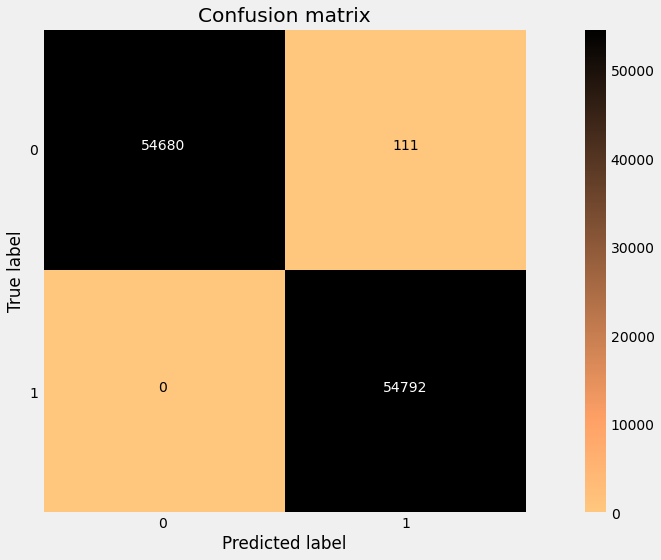

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54791
           1       1.00      1.00      1.00     54792

    accuracy                           1.00    109583
   macro avg       1.00      1.00      1.00    109583
weighted avg       1.00      1.00      1.00    109583



In [ ]:
cnf_matrix=metrics.confusion_matrix(ytest,(np.mean(np.column_stack(final_test_predictions_mp), axis=1)).round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()


print(classification_report(ytest,(np.mean(np.column_stack(final_test_predictions_mp), axis=1)).round()))

## **Saving Neural Network Model**

In [ ]:
# Save the model
"""Save the model"""
output_file = f'model_mp.bin'
with open(output_file, 'wb') as f_out:
    pickle.dump((model_mp), f_out)

print(f'the model is saved to {output_file}')

the model is saved to model_mp.bin


## **Voting Classifier**
- This type of ensemble is one of the most intuitive and easy to understand. The Voting Classifier is a homogeneous and heterogeneous type of Ensemble Learning, that is, the base classifiers can be of the same or different type. As mentioned earlier, this type of ensemble also works as an extension of bagging (e.g. Random Forest).

- The architecture of a Voting Classifier is made up of a number “n” of ML models, whose predictions are valued in two different ways: hard and soft. In hard mode, the winning prediction is the one with “the most votes”. In Figure 2 we see an example of how the Voting Classifier works in hard mode.

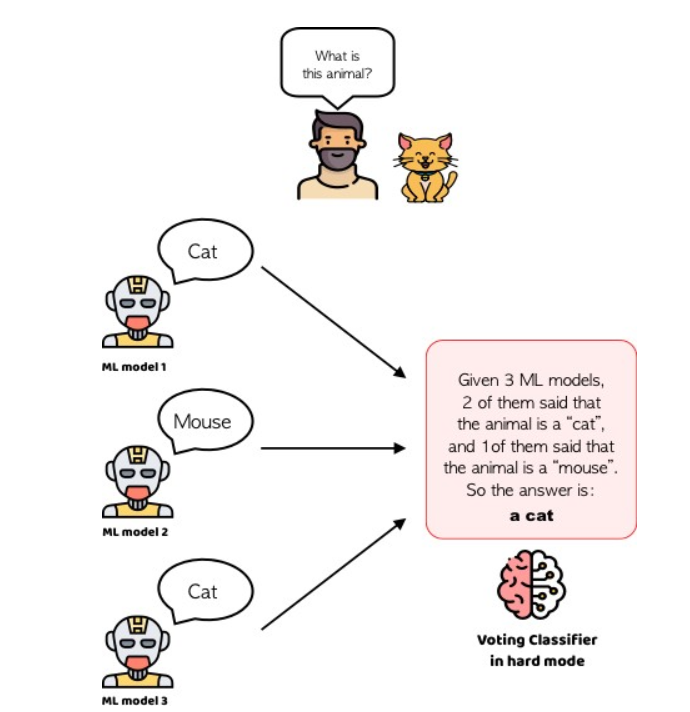

- On the other hand, the Voting Classifier in soft mode considers the probabilities thrown by each ML model, these probabilities will be weighted and averaged, consequently the winning class will be the one with the highest weighted and averaged probability. In Figure 3 we see an example of how the Voting Classifier works in the soft mode.

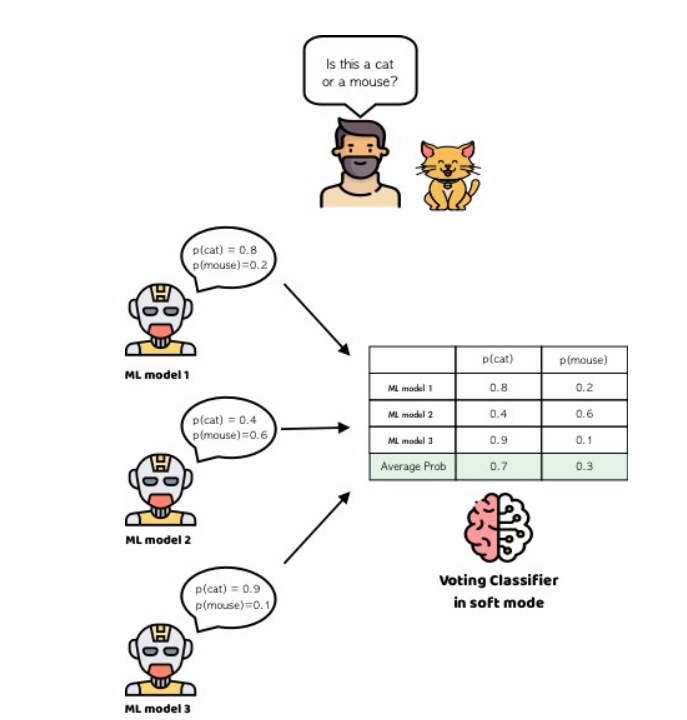

## **Load the models and using it for voting classifier**


In [ ]:
model_files  = ['model_rf.bin', 'model_xgb.bin', 'model_mp.bin'] 
for model_file in model_files:
  with open(model_file, 'rb') as f_in:
    if model_file == 'model_rf.bin':
      model_rf1 = pickle.load(f_in)
    if model_file == 'model_xgb.bin':
      model_xgb1 = pickle.load(f_in)
    if model_file == 'model_mp.bin':
      model_mp1 = pickle.load(f_in)

In [ ]:
%%time
useful_features = [c for c in df_train.columns if c not in ("Class")]

final_test_predictions_vclf = [] #to store final test predictions
final_valid_predictions_vclf = [] # to store final validation predictions
scores = [] #to store the scores

for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )): # Creating Strtify-5-Folds
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]       # Creating xtrain and ytrain
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]       # Creating xvalid and yvalid
    xtest, ytest = df_test.copy(), df_test['Class'].copy()                            # Creating xtest and ytest
    
    # Removing Class varaibles from xtrain, xvalid and xtest
    xtrain = xtrain[useful_features].values
    xvalid = xvalid[useful_features].values
    xtest = xtest[useful_features].values
    
    model_vclf = VotingClassifier(estimators=[ ('ANN', model_mp1),                    # Passing first model- MLPClassifier
                                              ('XGBoostClassifier', model_xgb1),      # Passing second model - XGBoost
                                              ('RandomForestClassifier', model_rf1)], # Passing third model - RandomForestClassifier
                                  voting='soft')                                      # Used Soft voting
    model_vclf.fit(xtrain, ytrain)                                                    # Training the model

    preds_valid = model_vclf.predict_proba(xvalid)[:, 1]                              # Prediction on validation data
    test_preds = model_vclf.predict_proba(xtest)[:, 1]                                # Prediction on test data
    final_test_predictions_vclf.append(test_preds)                                    # Appending test predictions to list
    final_valid_predictions_vclf.append(preds_valid)                                  # Appending validation predictions to list
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)                  # Evaluating validation predictions using roc_auc_score
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)                     # Evaluating Test predictions using roc_auc_score
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)                            # Printing fold and AUC_validation
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)                              # Printing fold and AUC_test
    scores.append(roc_auc_score_valid)                                                # Appending validation score to list
    
    
print(np.mean(scores), np.std(scores))                                                # Printing Mean and Standard Deviation of Scores.

Fold 0 AUC_valid:  0.9999657927394172
Fold 0 AUC_test:  0.9999964021952902
Fold 1 AUC_valid:  0.9999838585930012
Fold 1 AUC_test:  0.9999937010936892
Fold 2 AUC_valid:  0.9999759619874814
Fold 2 AUC_test:  0.9999960504425105
Fold 3 AUC_valid:  0.9999827853791481
Fold 3 AUC_test:  0.9999939266018634
Fold 4 AUC_valid:  0.9999548339355128
Fold 4 AUC_test:  0.9999917454681498
0.9999726465269122 1.098873827899222e-05
CPU times: user 19min 30s, sys: 4.15 s, total: 19min 34s
Wall time: 19min 25s


## **Evaluation of Voting Classifier model**

Confusion matrix, without normalization
[[54762    29]
 [    0 54792]]


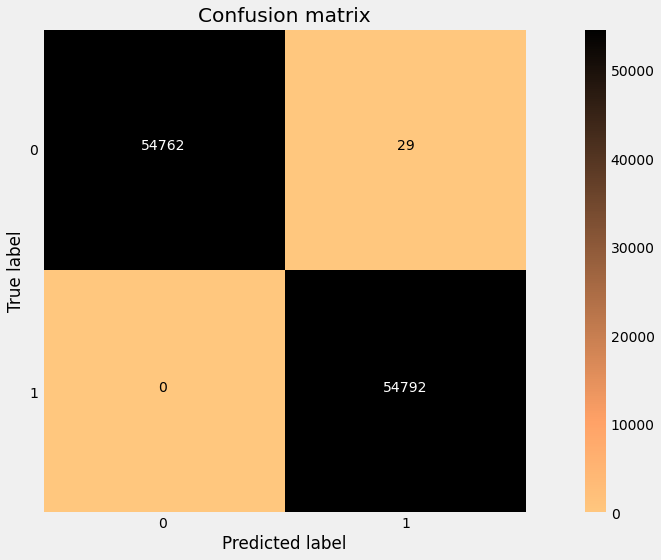



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54791
           1       1.00      1.00      1.00     54792

    accuracy                           1.00    109583
   macro avg       1.00      1.00      1.00    109583
weighted avg       1.00      1.00      1.00    109583



In [ ]:
cnf_matrix=metrics.confusion_matrix(ytest,(np.mean(np.column_stack(final_test_predictions_vclf), axis=1)).round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()
print('\n')

print(classification_report(ytest,(np.mean(np.column_stack(final_test_predictions_vclf), axis=1)).round()))



## **Save the final model-Voting Classifier**

In [ ]:
# Save the model
"""Save the model"""
output_file = f'model_vclf.bin'
with open(output_file, 'wb') as f_out:
    pickle.dump((model_vclf), f_out)

print(f'the model is saved to {output_file}')

the model is saved to model_vclf.bin


# **Trying out our model on random data.** 
- **Let's randomly take one row from the data and try predict using Voting Classifier.**


In [ ]:
query_data = df.iloc[602]
query_data

V1                  -3.043541
V2                  -2.701195
V3                   1.088463
V4                   2.288644
V5                   1.359805
V6                  -1.064823
V7                   0.325574
V8                  -0.067794
V9                  -0.270953
V10                 -0.838587
V11                 -0.414575
V12                 -0.503141
V13                  0.676502
V14                 -1.692029
V15                  2.000635
V16                  0.666780
V17                  0.599717
V18                  1.725321
V19                  0.283345
V20                  2.102339
V21                  0.661696
V22                  0.435477
V23                  0.611819
V24                 -0.293803
V25                  0.279798
V26                 -0.145362
V27                 -0.252773
V28                  0.035764
normalized_amount    3.574933
normalized_time     -1.995194
Class                1.000000
Name: 602, dtype: float64

In [ ]:
random_data = np.array(query_data.drop(['Class'], axis = 0)).reshape(1,-1)
random_data

array([[-3.04354062, -2.70119496,  1.08846278,  2.28864362,  1.35980513,
        -1.06482252,  0.32557427, -0.06779365, -0.27095284, -0.83858656,
        -0.41457545, -0.50314086,  0.67650154, -1.69202893,  2.00063484,
         0.6667797 ,  0.59971741,  1.72532101,  0.28334483,  2.10233879,
         0.66169592,  0.43547721,  0.61181867, -0.29380315,  0.27979803,
        -0.14536171, -0.25277312,  0.03576423,  3.57493274, -1.99519441]])

In [ ]:
print(f"Original Class: {query_data['Class']}, Predicted Class (==1) Probability: {model_vclf.predict_proba(random_data)[:,1][0]}")

Original Class: 1.0, Predicted Class (==1) Probability: 0.9426304972087737


In [ ]:
print(f"Original Class: {query_data['Class']}, Predicted Class: {model_vclf.predict(random_data)[0]}")

Original Class: 1.0, Predicted Class: 1


# **Conclusion:**

---


- **We started with given data which was unbalanced**
- **Challenge was to balance the dataset which was achieved by using SMOTETomek Impact of unbalanced data was explained by training and comparing 3 different models using sample of data.**
- **Standardization of variables was required as Amount and Time variables had huge values which could have degraded the resultant scores.**
- **Outliers were handled using capping and flooring technique and same was visualized in the notebook.** 
- **We hyper-tuned 3 models using Optuna:** 
  - **Random Forest**
  - **Xgboost**
  - **MLPClassifier (Neural Network)**
- **These hyper-tuned parameters were used to build respective models and every model was evaluated separately using:**
  - **roc_auc_score during hyper-parameter tuning and training phase**
  - **confusion_matrix and classification_report on test data during prediction phase.**
- **Finally these 3 models (RF, XGB and MLP) were passed to Voting Classifier with soft-voting technique and final predictions were made.**
- **Evaulation of Voting Classifier:**
  - **roc_auc_score during training phase**
  - **confusion_matrix and classification_report on test  data during prediction phase.**